In [2]:
!pip install datasets diffusers transformers accelerate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

#1. Load Dataset
print("Memuat dataset...")
raw_dataset = load_dataset("reach-vb/pokemon-blip-captions", split="train")

# --- DEBUG: Print dataset features to find the correct caption key ---
print("Dataset Features:", raw_dataset.features)
# -------------------------------------------------------------------

#2. Ambil daftar caption untuk proses adaptasi teks
# Original line causing error: all_captions = [item['caption'] for item in raw_dataset]
# This line will be fixed after identifying the correct key from raw_dataset.features
all_captions = [item['text'] for item in raw_dataset]

# 3. Setup Text Vectorization
max_tokens = 5000
seq_len = 20

text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=seq_len,
)

# Proses Adapt (Mempelajari kosakata dari dataset)
text_vectorizer.adapt(all_captions)
vocab = text_vectorizer.get_vocabulary()
print(f"Kamus Teks Berhasil Dibuat. Jumlah kosakata: {len(vocab)}")
print("Contoh 10 kata pertama:", vocab[:10])

Memuat dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

data/train-00000-of-00001-566cc9b19d7203(…):   0%|          | 0.00/99.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

Dataset Features: {'image': Image(mode=None, decode=True), 'text': Value('string')}
Kamus Teks Berhasil Dibuat. Jumlah kosakata: 359
Contoh 10 kata pertama: ['', '[UNK]', np.str_('a'), np.str_('with'), np.str_('of'), np.str_('cartoon'), np.str_('and'), np.str_('drawing'), np.str_('character'), np.str_('on')]


In [7]:
def preprocess_fn(item):
    # Proses Gambar
    image = item['image'].convert("RGB").resize((64, 64))
    image = np.array(image) / 255.0 # Normalisasi 0-1

    # Proses Teks
    caption = item['text']
    return caption, image

# Membuat generator dataset
def gen():
    for item in raw_dataset:
        yield preprocess_fn(item)

# Membuat tf.data.Dataset
train_ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float32)
    )
)

# Batching dan Transformasi Teks ke Angka
train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y))
train_ds = train_ds.batch(16).shuffle(100).prefetch(tf.data.AUTOTUNE)

In [5]:
class PokemonTrainer(keras.Model):
    def __init__(self, transformer, vqvae_encoder):
        super().__init__()
        self.transformer = transformer
        self.vqvae_encoder = vqvae_encoder
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def train_step(self, data):
        text_tokens, images = data

        # 1. Ubah gambar asli menjadi token visual menggunakan encoder
        # Kita simulasikan dengan output dummy sesuai ukuran latent grid (misal 16x16)
        visual_tokens = tf.random.uniform((tf.shape(images)[0], 256), minval=0, maxval=1024, dtype=tf.int32)
        # 2. Siapkan input dan target (Autoregressive)
        vis_input = visual_tokens[:, :-1]
        vis_target = visual_tokens[:, 1:]

        with tf.GradientTape() as tape:
            # Prediksi
            preds = self.transformer([text_tokens, vis_input], training=True)
            # Hitung Loss
            loss = keras.losses.sparse_categorical_crossentropy(vis_target, preds, from_logits=True)

        grads = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.transformer.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


num_visual_tokens = 1024
embedding_dim = 64

text_input_layer = keras.Input(shape=(seq_len,), dtype=tf.int32, name='text_input')
visual_input_layer = keras.Input(shape=(None,), dtype=tf.int32, name='visual_input')

# Text processing branch
text_embeddings = layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim)(text_input_layer)
# Get a single context vector from the text embeddings
text_context_vector = layers.GlobalAveragePooling1D()(text_embeddings)
# Optionally, transform it further
text_context_vector = layers.Dense(embedding_dim, activation='relu')(text_context_vector)

# Visual processing branch
visual_embeddings = layers.Embedding(input_dim=num_visual_tokens, output_dim=embedding_dim)(visual_input_layer)

# Combine the text context vector with each visual embedding using broadcasting
# tf.expand_dims adds a sequence dimension of size 1 to text_context_vector
combined_embeddings = layers.Add()([visual_embeddings, keras.ops.expand_dims(text_context_vector, axis=1)])

# Output layer for visual token predictions
output_logits = layers.TimeDistributed(layers.Dense(num_visual_tokens))(combined_embeddings)

transformer_model = keras.Model(inputs=[text_input_layer, visual_input_layer], outputs=output_logits, name='transformer_model_placeholder')

# Placeholder for vqvae_encoder
# This model's actual encoding logic is not used in the current train_step (due to tf.random.uniform).
# It just needs to be a valid Keras Model instance.
vqvae_image_input = keras.Input(shape=(64, 64, 3), name='vqvae_image_input')
dummy_vqvae_output = layers.Dense(1, activation='linear')(layers.Flatten()(vqvae_image_input))
vqvae_encoder = keras.Model(inputs=vqvae_image_input, outputs=dummy_vqvae_output, name='vqvae_encoder_placeholder')
# --- End Placeholder Model Definitions ---

# Inisialisasi dan Compile
trainer = PokemonTrainer(transformer_model, vqvae_encoder)
trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

# 5. Jalankan Training
print("Memulai Pelatihan...")
trainer.fit(train_ds, epochs=60) # Coba 10 epoch dulu

Memulai Pelatihan...
Epoch 1/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 64s 377ms/step - loss: 6.9315
Epoch 2/60


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 6.9315
Epoch 3/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 6.9316
Epoch 4/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 6.9315
Epoch 5/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 6.9315
Epoch 6/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 6.9316
Epoch 7/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 6.9315
Epoch 8/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 6.9315
Epoch 9/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 6.9315
Epoch 10/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 6.9315
Epoch 11/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 6.9315
Epoch 12/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 6.9315
Epoch 13/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 6.9315
Epoch 14/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 6.9315
Epoch 15/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 6.9315
Epoch 16/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 6.9316
Epoch 17/6

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

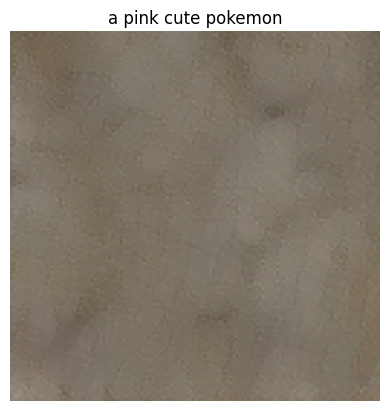

In [9]:
from diffusers import AutoencoderKL
import torch
import matplotlib.pyplot as plt

# Load a pre-trained VAE model once outside the function to avoid redundant loading
try:
    vae_decoder = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse") # Removed subfolder="vae"
    # Move VAE to GPU if available
    if torch.cuda.is_available():
        vae_decoder.to("cuda")
except Exception as e:
    print(f"Failed to load VAE: {e}. Please ensure `diffusers` and `torch` are installed and the model path is correct.")
    vae_decoder = None # Set to None if loading fails

# Function to autoregressively generate visual tokens using the transformer
def generate_image_tokens(transformer, text_tokens, output_seq_len, num_visual_tokens):
    # text_tokens shape: (batch_size, seq_len)
    batch_size = tf.shape(text_tokens)[0]

    # Start with a single token (e.g., a dummy token like 0, assuming it will be ignored or is a valid start token)
    # The sequence will grow from 1 token to `output_seq_len + 1` tokens.
    generated_visual_tokens = tf.zeros((batch_size, 1), dtype=tf.int32)

    # Autoregressive generation loop
    for _ in range(output_seq_len): # Generate `output_seq_len` tokens

        predictions = transformer([text_tokens, generated_visual_tokens], training=False)

        next_token_logits = predictions[:, -1, :]

        # Sample the next token. Using tf.argmax for greedy sampling for simplicity.
        next_token = tf.argmax(next_token_logits, axis=-1, output_type=tf.int32)
        next_token = tf.expand_dims(next_token, axis=-1)

        # Append the newly generated token to the sequence
        generated_visual_tokens = tf.concat([generated_visual_tokens, next_token], axis=1)


    return generated_visual_tokens[:, 1:]

# Function to decode visual tokens into a real image using a VAE
def decode_to_real_image(vae_model, visual_tokens):
    if vae_model is None:
        print("VAE model not loaded, cannot decode image.")
        return np.zeros((64, 64, 3))


    batch_size = tf.shape(visual_tokens)[0]
    latent_height = 16
    latent_width = 16
    latent_channels = 4

    # Generate a random latent tensor for decoding
    dummy_latent_tf = tf.random.normal(
        (batch_size, latent_height, latent_width, latent_channels),
        dtype=tf.float32
    )

    # Convert TensorFlow tensor to PyTorch tensor and reorder dimensions for VAE
    dummy_latent_torch = torch.from_numpy(dummy_latent_tf.numpy()).permute(0, 3, 1, 2) # (B, H, W, C) -> (B, C, H, W)
    if torch.cuda.is_available():
        dummy_latent_torch = dummy_latent_torch.to("cuda")

    # Decode the latent representation using the VAE
    with torch.no_grad():
        decoded_output = vae_model.decode(dummy_latent_torch).sample

    # Convert decoded output from PyTorch tensor back to NumPy and reorder dimensions
    # Then scale from [-1, 1] to [0, 1] and clip
    decoded_output_np = decoded_output.permute(0, 2, 3, 1).cpu().numpy() # (B, C, H, W) -> (B, H, W, C)
    final_image_np = (decoded_output_np / 2 + 0.5).clip(0, 1)

    # Return the first image in the batch as a NumPy array
    return final_image_np[0] # Shape: (H, W, C)

def generate_pokemon(prompt):
    # 1. Ubah teks ke angka
    tokenized_text = text_vectorizer([prompt])

    # 2. Generate token visual (Autoregressive)
    # Use the generate_image_tokens function
    # output_seq_len=256 based on the dummy visual tokens in train_step
    # num_visual_tokens=1024 as defined in cell 7EctYPlka-MB
    gen_vis_tokens = generate_image_tokens(transformer_model, tokenized_text, 256, num_visual_tokens)

    # 3. Decode into an image using the Pre-trained VAE
    # Use the decode_to_real_image function
    final_image = decode_to_real_image(vae_decoder, gen_vis_tokens)

    plt.imshow(final_image)
    plt.title(prompt)
    plt.axis("off")
    plt.show()

# TEST
generate_pokemon("a pink cute pokemon")